In [1]:
import cantera as ct
import numpy as np

from scipy.integrate import trapz
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta

#Input Parameters
#########################################################################
start = timer()
# # reaction mechanism, kinetics type and compositions

# reaction mechanism, kinetics type and compositions
# reaction_mechanism = 'nDodecane_Reitz.yaml'
reaction_mechanism = 'ethanol.yaml'
# phase_name = 'nDodecane_IG'
comp_air = 'O2:1, N2:3.76'
comp_fuel = 'C2H5OH:1'

phi = np.arange(0.1, 1.6, 0.1)
rpm = np.arange(3000., 13000., 1000.)

STATES = []
work = []
heat = []
efficiency = []

for j in rpm:
    for i in phi:
        f = j / 60.  # engine speed [1/s] (3000 rpm)
        V_H = 1600e-6 / 6 # displaced volume [m**3]
        epsilon = 18.  # compression ratio [-]
        d_piston = 0.08  # piston diameter [m]

        # turbocharger temperature, pressure, and composition
        T_inlet = 400.  # K
        p_inlet = 1.3e5  # Pa
        comp_inlet = comp_air

        # outlet pressure
        p_outlet = 1.2e5  # Pa

        # fuel properties (gaseous!)
        T_injector = 300.  # K
        p_injector = 1600e5  # Pa
        comp_injector = comp_fuel

        # ambient properties
        T_ambient = 300.  # K
        p_ambient = 1e5  # Pa
        comp_ambient = comp_air

        # Inlet valve friction coefficient, open and close timings
        inlet_valve_coeff = 1.e-6
        inlet_open = -18. / 180. * np.pi
        inlet_close = 198. / 180. * np.pi

        # Outlet valve friction coefficient, open and close timings
        outlet_valve_coeff = 1.e-6
        outlet_open = 522. / 180 * np.pi
        outlet_close = 18. / 180. * np.pi

        # Fuel mass, injector open and close timings
        injector_open = 350. / 180. * np.pi
        injector_close = 365. / 180. * np.pi

        # Simulation time and parameters
        sim_n_revolutions = 8
        delta_T_max = 20.
        rtol = 1.e-12
        atol = 1.e-16

        #####################################################################
        # Set up IC engine Parameters and Functions
        #####################################################################

        V_oT = V_H / (epsilon - 1.)
        A_piston = 0.25 * np.pi * d_piston ** 2
        stroke = V_H / A_piston


        def crank_angle(t):
            """Convert time to crank angle"""
            return np.remainder(2 * np.pi * f * t, 4 * np.pi)


        def piston_speed(t):
            """Approximate piston speed with sinusoidal velocity profile"""
            return - stroke / 2 * 2 * np.pi * f * np.sin(crank_angle(t))

        #####################################################################
        # Set up Reactor Network
        #####################################################################

        # load reaction mechanism
        gas = ct.Solution(reaction_mechanism)
        # define initial state and set up reactor
        gas.TPX = T_inlet, p_inlet, comp_inlet
        cyl = ct.IdealGasReactor(gas)
        cyl.volume = V_oT
        oxid_mol = V_H*gas.density_mole
        stoich_fuel_mol = oxid_mol / (3*4.76)
        stoich_fuel_mass = 46.068 * stoich_fuel_mol

        # define inlet state
        gas.TPX = T_inlet, p_inlet, comp_inlet
        # Note: The previous line is technically not needed as the state of the gas object is
        # already set correctly; change if inlet state is different from the reactor state.
        inlet = ct.Reservoir(gas)

        # inlet valve
        inlet_valve = ct.Valve(inlet, cyl)
        inlet_delta = np.mod(inlet_close - inlet_open, 4 * np.pi)
        inlet_valve.valve_coeff = inlet_valve_coeff
        inlet_valve.time_function = (lambda t: np.mod(crank_angle(t) - inlet_open, 4 * np.pi) < inlet_delta)

        # define injector state (gaseous!)
        gas.TPX = T_injector, p_injector, comp_injector
        injector = ct.Reservoir(gas)

        ##############################
        # the mass of fuel required is determined my the equivalence ratio
        # the mass of fuel require for stoichiometric combustion is 
        injector_mass = i * stoich_fuel_mass  # kg
        print(injector_mass)

        # injector is modeled as a mass flow controller
        injector_mfc = ct.MassFlowController(injector, cyl)
        injector_delta = np.mod(injector_close - injector_open, 4 * np.pi)
        injector_t_open = (injector_close - injector_open) / 2. / np.pi / f
        injector_mfc.mass_flow_coeff = injector_mass / injector_t_open
        injector_mfc.time_function = (lambda t: np.mod(crank_angle(t) - injector_open, 4 * np.pi) < injector_delta)

        # define outlet pressure (temperature and composition don't matter)
        gas.TPX = T_ambient, p_outlet, comp_ambient
        outlet = ct.Reservoir(gas)

        # outlet valve
        outlet_valve = ct.Valve(cyl, outlet)
        outlet_delta = np.mod(outlet_close - outlet_open, 4 * np.pi)
        outlet_valve.valve_coeff = outlet_valve_coeff
        outlet_valve.time_function = (lambda t: np.mod(crank_angle(t) - outlet_open, 4 * np.pi) < outlet_delta)

        # define ambient pressure (temperature and composition don't matter)
        gas.TPX = T_ambient, p_ambient, comp_ambient
        ambient_air = ct.Reservoir(gas)

        # piston is modeled as a moving wall
        piston = ct.Wall(ambient_air, cyl)
        piston.area = A_piston
        piston.velocity = piston_speed

        # create a reactor network containing the cylinder and limit advance step
        sim = ct.ReactorNet([cyl])
        sim.rtol, sim.atol = rtol, atol
        cyl.set_advance_limit('temperature', delta_T_max)

        #####################################################################
        # Run Simulation
        #####################################################################

        # set up output data arrays
        states = ct.SolutionArray(
            cyl.thermo,
            extra=('t', 'ca', 'V', 'm', 'mdot_in', 'mdot_out', 'dWv_dt'),
        )

        # simulate with a maximum resolution of 1 deg crank angle
        dt = 0.1 * 1. / (360 * f)
        t_stop = sim_n_revolutions / f
        while sim.time < t_stop:

            # perform time integration
            sim.advance(sim.time + dt)

            # calculate results to be stored
            dWv_dt = - (cyl.thermo.P - ambient_air.thermo.P) * A_piston * \
                piston_speed(sim.time)

            # append output data
            states.append(cyl.thermo.state,
                          t=sim.time, ca=crank_angle(sim.time),
                          V=cyl.volume, m=cyl.mass,
                          mdot_in=inlet_valve.mass_flow_rate,
                          mdot_out=outlet_valve.mass_flow_rate,
                          dWv_dt=dWv_dt)
        t = states.t
        W = trapz(states.dWv_dt, t)
        work.append(W / t[-1] / 1000.)
        Q = trapz(states.heat_release_rate * states.V, t)
        heat.append(Q / t[-1] / 1000.)
        efficiency.append((W / Q) * 100)
        
        STATES.append(states)
        end = timer()
        print(timedelta(seconds=end-start))
    print(len(work))
        
    end = timer()
    print(timedelta(seconds=end-start))
    #t = states.t

    #output_str = '{:45s}{:>4.1f} {}'
    #W = trapz(states.dWv_dt, t)
    #print(output_str.format('Expansion power per cylinder (estimate):', W / t[-1] / 1000., 'kW'))
    
print(timedelta(seconds=end-start))

3.362707239841641e-06
0:00:08.072399
6.725414479683282e-06
0:00:16.633861
1.0088121719524924e-05
0:00:26.146502
1.3450828959366563e-05
0:00:35.575674
1.6813536199208203e-05
0:00:45.416047
2.0176243439049844e-05
0:00:55.772818
2.3538950678891486e-05
0:01:06.540006
2.6901657918733127e-05
0:01:19.819004
3.0264365158574765e-05
0:01:32.467824
3.3627072398416406e-05
0:01:47.072225
3.698977963825805e-05
0:01:59.611095
4.0352486878099695e-05
0:02:13.628478
4.3715194117941337e-05
0:02:26.512423
4.707790135778297e-05
0:02:39.402194
5.044060859762462e-05
0:02:52.031207
15
0:02:52.031284
3.362707239841641e-06
0:03:00.719845
6.725414479683282e-06
0:03:10.035681
1.0088121719524924e-05
0:03:19.950865
1.3450828959366563e-05
0:03:30.743446
1.6813536199208203e-05
0:03:42.380532
2.0176243439049844e-05
0:03:54.107973
2.3538950678891486e-05
0:04:06.172261
2.6901657918733127e-05
0:04:17.185774
3.0264365158574765e-05
0:04:29.755602
3.3627072398416406e-05
0:04:42.423378
3.698977963825805e-05
0:04:54.073069
4.

<function matplotlib.pyplot.show(close=None, block=None)>

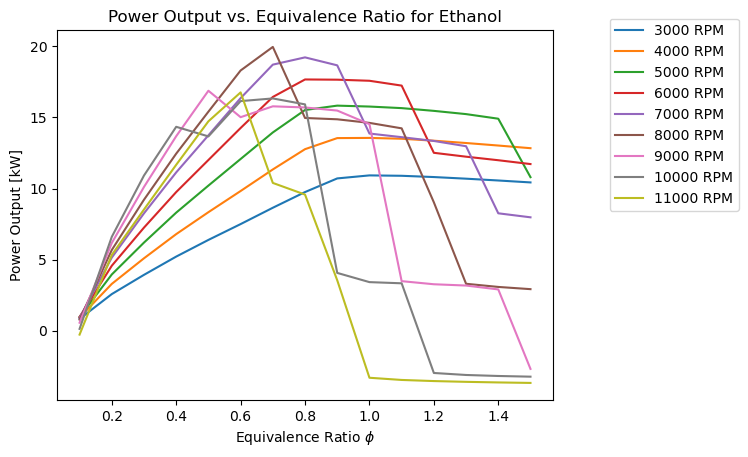

In [3]:
fig, ax = plt.subplots()

ax.set_xlabel('Equivalence Ratio $\phi$')
ax.set_ylabel('Power Output [kW]')
ax.set_title('Power Output vs. Equivalence Ratio for Ethanol')
ax.plot(phi, work[0:len(phi)], label='3000 RPM')
ax.plot(phi, work[len(phi):2*len(phi)], label='4000 RPM')
ax.plot(phi, work[2*len(phi):3*len(phi)], label='5000 RPM')
ax.plot(phi, work[3*len(phi):4*len(phi)], label='6000 RPM')
ax.plot(phi, work[4*len(phi):5*len(phi)], label='7000 RPM')
ax.plot(phi, work[5*len(phi):6*len(phi)], label='8000 RPM')
ax.plot(phi, work[6*len(phi):7*len(phi)], label='9000 RPM')
ax.plot(phi, work[7*len(phi):8*len(phi)], label='10000 RPM')
ax.plot(phi, work[8*len(phi):9*len(phi)], label='11000 RPM')
# ax.plot(phi, work[9*len(phi):10*len(phi)], label='12000 RPM')
# ax.plot(phi, work[10*len(phi):11*len(phi)], label='13000 RPM')
# ax.plot(phi, work[11*len(phi):12*len(phi)], label='14000 RPM')
# ax.plot(phi, work[12*len(phi):13*len(phi)], label='15000 RPM')


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

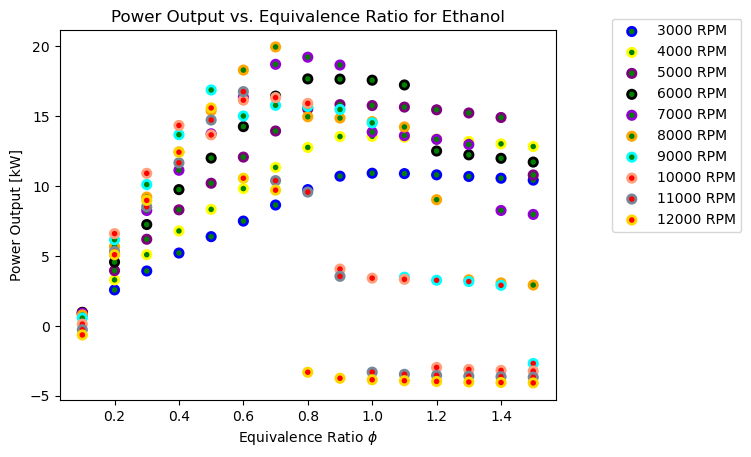

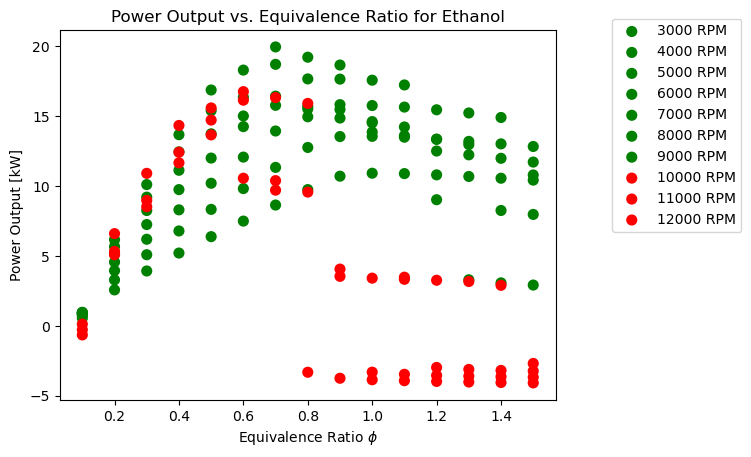

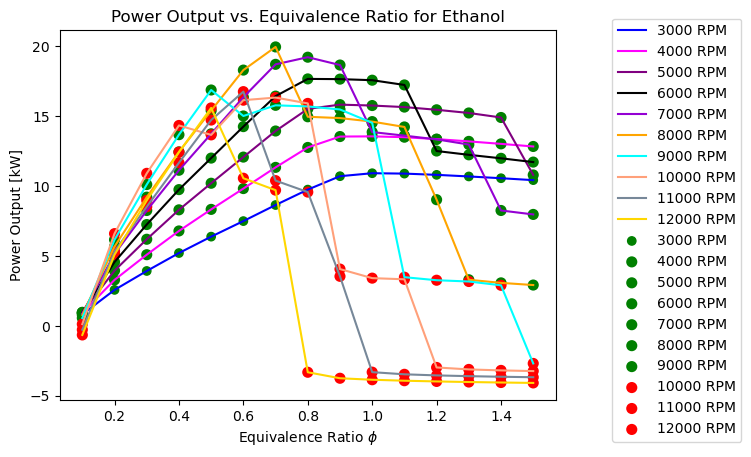

In [5]:
reaction_mechanism = 'ethanol.yaml'
comp_air = 'O2:1, N2:3.76'
comp_fuel = 'C2H5OH:1'

T_inlet = 400.  # K
p_inlet = 1.3e5  # Pa
comp_inlet = comp_air

V_H = 1600e-6 / 6 # displaced volume [m**3]

cyl_num = 6

gas = ct.Solution(reaction_mechanism)
# define initial state and set up reactor
gas.TPX = T_inlet, p_inlet, comp_inlet

oxid_mol = V_H*gas.density_mole
stoich_fuel_mol = oxid_mol / (3*4.76)
stoich_fuel_mass = 46.068 * stoich_fuel_mol


phi = np.arange(0.1, 1.6, 0.1)
rpm = np.arange(3000., 16000., 1000.)

fuel_mass_flow_rate = []

for j in rpm:
    for i in phi:
        f = j / 60.
        inj_freq = f / 2
        injector_mass = i * stoich_fuel_mass
        fuel_mass_flow_rate.append(cyl_num * inj_freq * injector_mass * 3600)

colors = []
for k in range(0, len(fuel_mass_flow_rate)):
    if k >= 100:
        colors.append('r')
    else:
        colors.append('g')

        
fig, ax = plt.subplots()

ax.set_xlabel('Equivalence Ratio $\phi$')
ax.set_ylabel('Power Output [kW]')
ax.set_title('Power Output vs. Equivalence Ratio for Ethanol')
ax.scatter(phi, work[0:len(phi)], edgecolors = 'blue', c = colors[0:len(phi)], label='3000 RPM', linewidths = 2)
ax.scatter(phi, work[len(phi):2*len(phi)], edgecolors = 'yellow',c = colors[0:len(phi)], label='4000 RPM', linewidths = 2)
ax.scatter(phi, work[2*len(phi):3*len(phi)], edgecolors = 'purple',c = colors[2*len(phi):3*len(phi)], label='5000 RPM', linewidths = 2)
ax.scatter(phi, work[3*len(phi):4*len(phi)], edgecolors = 'black',c = colors[3*len(phi):4*len(phi)], label='6000 RPM', linewidths = 2)
ax.scatter(phi, work[4*len(phi):5*len(phi)], edgecolors = 'darkviolet',c = colors[4*len(phi):5*len(phi)], label='7000 RPM',linewidths = 2)
ax.scatter(phi, work[5*len(phi):6*len(phi)], edgecolors = 'orange',c = colors[5*len(phi):6*len(phi)], label='8000 RPM', linewidths = 2)
ax.scatter(phi, work[6*len(phi):7*len(phi)], edgecolors = 'cyan',c = colors[6*len(phi):7*len(phi)], label='9000 RPM', linewidths = 2)
ax.scatter(phi, work[7*len(phi):8*len(phi)], edgecolors = 'lightsalmon',c = colors[7*len(phi):8*len(phi)], label='10000 RPM', linewidths = 2)
ax.scatter(phi, work[8*len(phi):9*len(phi)], edgecolors = 'lightslategray',c = colors[8*len(phi):9*len(phi)], label='11000 RPM', linewidths = 2)
ax.scatter(phi, work[9*len(phi):10*len(phi)], edgecolors = 'gold',c = colors[9*len(phi):10*len(phi)], label='12000 RPM', linewidths = 2)
# ax.scatter(phi, work[10*len(phi):11*len(phi)], edgecolors = 'olive',c = colors[10*len(phi):11*len(phi)], label='13000 RPM', linewidths = 2)
# ax.scatter(phi, work[11*len(phi):12*len(phi)], edgecolors = 'lightblue',c = colors[11*len(phi):12*len(phi)], label='14000 RPM', linewidths = 2)
# ax.scatter(phi, work[12*len(phi):13*len(phi)], edgecolors = 'lightcyan',c = colors[12*len(phi):13*len(phi)], label='15000 RPM', linewidths = 2)


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show
        
fig, ax = plt.subplots()

ax.set_xlabel('Equivalence Ratio $\phi$')
ax.set_ylabel('Power Output [kW]')
ax.set_title('Power Output vs. Equivalence Ratio for Ethanol')
ax.scatter(phi, work[0:len(phi)], c = colors[0:len(phi)], label='3000 RPM', linewidths = 2)
ax.scatter(phi, work[len(phi):2*len(phi)], c = colors[0:len(phi)], label='4000 RPM', linewidths = 2)
ax.scatter(phi, work[2*len(phi):3*len(phi)], c = colors[2*len(phi):3*len(phi)], label='5000 RPM', linewidths = 2)
ax.scatter(phi, work[3*len(phi):4*len(phi)], c = colors[3*len(phi):4*len(phi)], label='6000 RPM', linewidths = 2)
ax.scatter(phi, work[4*len(phi):5*len(phi)], c = colors[4*len(phi):5*len(phi)], label='7000 RPM',linewidths = 2)
ax.scatter(phi, work[5*len(phi):6*len(phi)], c = colors[5*len(phi):6*len(phi)], label='8000 RPM', linewidths = 2)
ax.scatter(phi, work[6*len(phi):7*len(phi)], c = colors[6*len(phi):7*len(phi)], label='9000 RPM', linewidths = 2)
ax.scatter(phi, work[7*len(phi):8*len(phi)], c = colors[7*len(phi):8*len(phi)], label='10000 RPM', linewidths = 2)
ax.scatter(phi, work[8*len(phi):9*len(phi)], c = colors[8*len(phi):9*len(phi)], label='11000 RPM', linewidths = 2)
ax.scatter(phi, work[9*len(phi):10*len(phi)], c = colors[9*len(phi):10*len(phi)], label='12000 RPM', linewidths = 2)
# ax.scatter(phi, work[10*len(phi):11*len(phi)], c = colors[10*len(phi):11*len(phi)], label='13000 RPM', linewidths = 2)
# ax.scatter(phi, work[11*len(phi):12*len(phi)], c = colors[11*len(phi):12*len(phi)], label='14000 RPM', linewidths = 2)
# ax.scatter(phi, work[12*len(phi):13*len(phi)], c = colors[12*len(phi):13*len(phi)], label='15000 RPM', linewidths = 2)


plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show
    

fig, ax = plt.subplots()

ax.set_xlabel('Equivalence Ratio $\phi$')
ax.set_ylabel('Power Output [kW]')
ax.set_title('Power Output vs. Equivalence Ratio for Ethanol')
ax.plot(phi, work[0:len(phi)], c = 'blue', label='3000 RPM')
ax.plot(phi, work[len(phi):2*len(phi)], c = 'fuchsia', label='4000 RPM')
ax.plot(phi, work[2*len(phi):3*len(phi)], c = 'purple', label='5000 RPM')
ax.plot(phi, work[3*len(phi):4*len(phi)], c = 'black', label='6000 RPM')
ax.plot(phi, work[4*len(phi):5*len(phi)], c = 'darkviolet', label='7000 RPM')
ax.plot(phi, work[5*len(phi):6*len(phi)], c = 'orange', label='8000 RPM')
ax.plot(phi, work[6*len(phi):7*len(phi)], c = 'cyan', label='9000 RPM')
ax.plot(phi, work[7*len(phi):8*len(phi)], c = 'lightsalmon', label='10000 RPM')
ax.plot(phi, work[8*len(phi):9*len(phi)], c = 'lightslategray', label='11000 RPM')
ax.plot(phi, work[9*len(phi):10*len(phi)], c = 'gold', label='12000 RPM')
# ax.plot(phi, work[10*len(phi):11*len(phi)], c = 'olive', label='13000 RPM')
# ax.plot(phi, work[11*len(phi):12*len(phi)], c = 'lightblue', label='14000 RPM')
# ax.plot(phi, work[12*len(phi):13*len(phi)], c = 'maroon', label='15000 RPM')
ax.scatter(phi, work[0:len(phi)], c = colors[0:len(phi)], label='3000 RPM')
ax.scatter(phi, work[len(phi):2*len(phi)], c = colors[0:len(phi)], label='4000 RPM', linewidths = 2)
ax.scatter(phi, work[2*len(phi):3*len(phi)], c = colors[2*len(phi):3*len(phi)], label='5000 RPM', linewidths = 2)
ax.scatter(phi, work[3*len(phi):4*len(phi)], c = colors[3*len(phi):4*len(phi)], label='6000 RPM', linewidths = 2)
ax.scatter(phi, work[4*len(phi):5*len(phi)], c = colors[4*len(phi):5*len(phi)], label='7000 RPM',linewidths = 2)
ax.scatter(phi, work[5*len(phi):6*len(phi)], c = colors[5*len(phi):6*len(phi)], label='8000 RPM', linewidths = 2)
ax.scatter(phi, work[6*len(phi):7*len(phi)], c = colors[6*len(phi):7*len(phi)], label='9000 RPM', linewidths = 2)
ax.scatter(phi, work[7*len(phi):8*len(phi)], c = colors[7*len(phi):8*len(phi)], label='10000 RPM', linewidths = 2)
ax.scatter(phi, work[8*len(phi):9*len(phi)], c = colors[8*len(phi):9*len(phi)], label='11000 RPM', linewidths = 2)
ax.scatter(phi, work[9*len(phi):10*len(phi)], c = colors[9*len(phi):10*len(phi)], label='12000 RPM', linewidths = 2)
# ax.scatter(phi, work[10*len(phi):11*len(phi)], c = colors[10*len(phi):11*len(phi)], label='13000 RPM', linewidths = 2)
# ax.scatter(phi, work[11*len(phi):12*len(phi)], c = colors[11*len(phi):12*len(phi)], label='14000 RPM', linewidths = 2)
# ax.scatter(phi, work[12*len(phi):13*len(phi)], c = colors[12*len(phi):13*len(phi)], label='15000 RPM', linewidths = 2)

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show